In [1]:
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances,log_loss
from sklearn.metrics import mean_squared_error, pairwise_distances

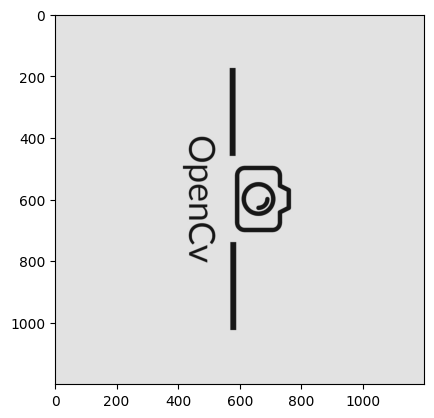

In [2]:
watermark = cv2.imread('3.jpeg')
watermark = cv2.rotate(watermark, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(watermark)
plt.show()

In [3]:
def scale(image,scale_width):
    height = image.shape[0]
    width = image.shape[1]
    scaled_height = (scale_width/height*width)
    scaled_height = int(scaled_height)
    #print(scale_width,scaled_height)
    resized_img = cv2.resize(image,(scale_width,scaled_height))
    return resized_img
watermark = scale(watermark,100)

# Image Inputs

In [4]:
import os
import pathlib
data_dir = './Image Dataset - Copy//'
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('Image Dataset - Copy')

In [5]:
img_list = list(data_dir.glob('*'))
oimg = []
for imgs in img_list:
    pic = cv2.imread(str(imgs))
    oimg.append(pic)

In [6]:
oimg = np.array(oimg)

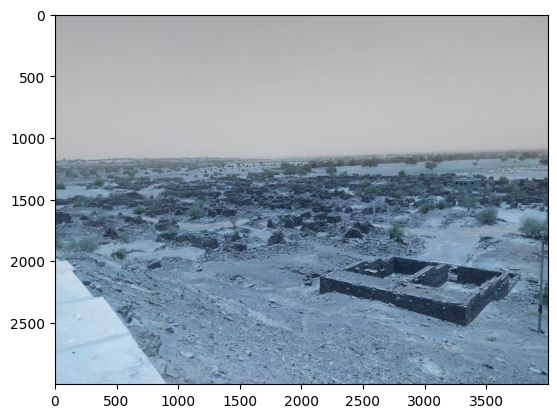

In [7]:
plt.imshow(oimg[10])

# Watermark Addition

In [8]:
def logloss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true * np.log(y_pred)).sum(axis=1).mean()

In [9]:
def watermark_func(x,watermark):
    new_img = []
    mse_loss = []
    path = 'E:\IIT JODHPUR AI\Courses Materials\Projects\Computer Vision\Rotated Watermarked Images'
    j=0
    watermark = scale(watermark,100)
    watermark_height = watermark.shape[0]
    watermark_width = watermark.shape[1]
    pairwise = []
    log = []
    for i in x:
        img_height = i.shape[0]
        img_width = i.shape[1]
        overlay = np.zeros((img_height,img_width,3),dtype='uint8')
        overlay[0:watermark_height,0:watermark_width] = watermark
        new = cv2.addWeighted(overlay.copy(),0.8,i.copy(),1.0,0,i.copy())
        new_img.append(new)
        k = "Rotated Watermarked Images/" +str(j)+".jpg"
        #print((k))
        j = j+1
        cv2.imwrite(str(k),new)
        mse_loss.append(mean_squared_error(i.reshape(3,img_height*img_width), new.reshape(3,img_height*img_width)))
        pairwise.append(pairwise_distances(i.reshape(3,img_height*img_width), new.reshape(3,img_height*img_width)).mean())
        log.append(logloss(i.reshape(3,img_height*img_width), new.reshape(3,img_height*img_width)))
    return new_img,mse_loss,pairwise,log

In [10]:
images,mse,pairwise,log = watermark_func(oimg,watermark)

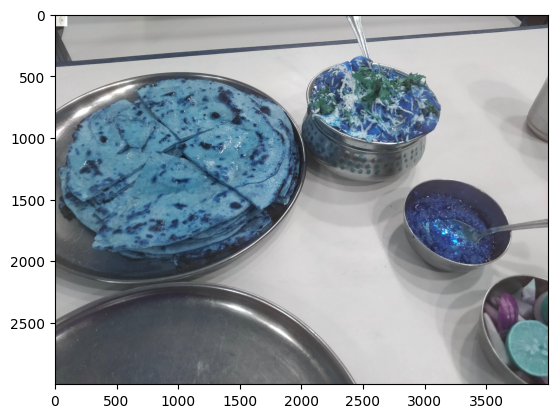

In [11]:
plt.imshow(images[0])

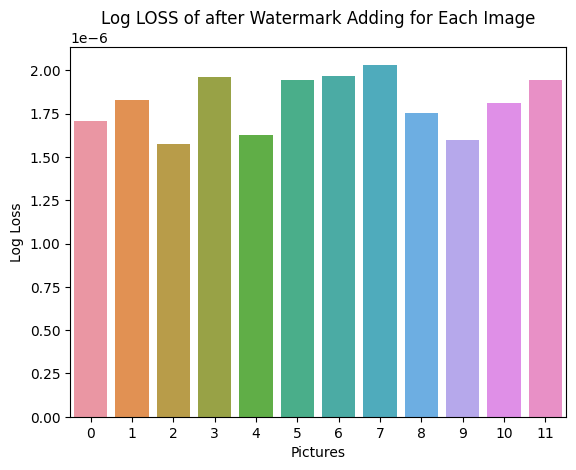

In [12]:
import seaborn as sns 
sns.barplot(y = log,x = np.arange(0,len(oimg),1))
plt.title("Log LOSS of after Watermark Adding for Each Image")
plt.xlabel('Pictures')
plt.ylabel('Log Loss')
plt.show()

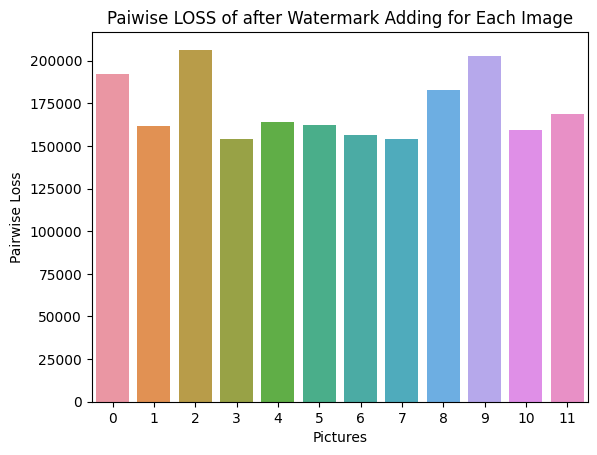

In [13]:
import seaborn as sns 
sns.barplot(y = pairwise,x = np.arange(0,len(oimg),1))
plt.title("Paiwise LOSS of after Watermark Adding for Each Image")
plt.xlabel('Pictures')
plt.ylabel('Pairwise Loss')
plt.show()

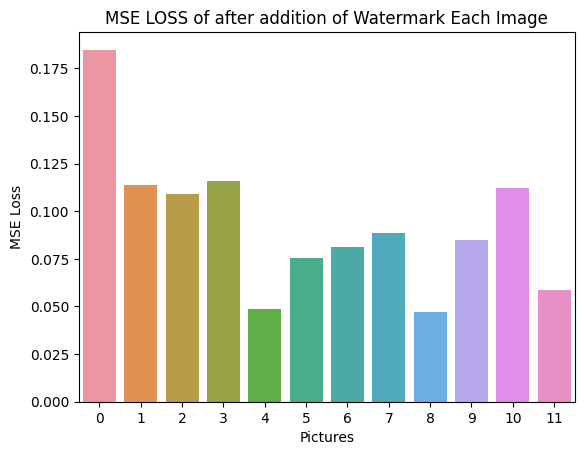

In [14]:
import seaborn as sns 
sns.barplot(y = mse,x = np.arange(0,len(oimg),1))
plt.title("MSE LOSS of after addition of Watermark Each Image")
plt.xlabel('Pictures')
plt.ylabel('MSE Loss')
plt.show()

# Reading the Watermarked Images

In [15]:
import os
import pathlib
data_dir = './Rotated Watermarked Images//'
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('Rotated Watermarked Images')

In [16]:
img_list = list(data_dir.glob('*'))
watermark_imgs = []
for imgs in img_list:
    pic = cv2.imread(str(imgs))
    watermark_imgs.append(pic)
watermark_imgs = np.array(watermark_imgs)

In [17]:
def sift_matching(imgs):
    template = cv2.imread('3.jpeg')
    template = scale(template,100)
    template_gray = cv2.cvtColor(template.copy(), cv2.COLOR_BGR2GRAY)
    detected = []
    removed = []
    mse_loss = []
    pairwise = []
    log = []
    j = 0
    for i,img in enumerate(imgs):
        img_height = img.shape[0]
        img_width = img.shape[1]
    # Convert the images to grayscale
        img_gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
    # Find the keypoints and descriptors for the template and the original image
        kp1, des1 = sift.detectAndCompute(template_gray, None)
        kp2, des2 = sift.detectAndCompute(img_gray, None)
    # Initialize the Brute-Force Matcher
        bf = cv2.BFMatcher()
        # Match the descriptors of the template and the original image
        matches = bf.match(des1, des2)
        # Get the coordinates of the matched keypoints in the original image
        matched_points_img = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        # Get the coordinates of the keypoints in the template
        matched_points_template = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        # Find the homography matrix using the matched keypoints
        homography, mask = cv2.findHomography(matched_points_img, matched_points_template, cv2.RANSAC, 5.0)
        # Get the corners of the template in the original image
        corners_template = np.float32([[0, 0], [0, template.shape[0]], [template.shape[1], template.shape[0]], [template.shape[1], 0]]).reshape(-1, 1, 2)
        corners_img = cv2.perspectiveTransform(corners_template, homography)
        # Find the bounding rectangle around the template in the original image
        x, y, w, h = cv2.boundingRect(corners_img.astype(int))
        # Draw the bounding rectangle around the template in the original image
        new=cv2.rectangle(img.copy(), (0, 0), (x+w*100, y+h*100), (0, 255, 0), 5)
        new=img.copy()
        top_left = [0,0]
        bottom_right = (top_left[0] + w*100, top_left[1] + h*100)
        # Create a mask of the area to be inpainted
        mask = np.zeros(new.shape[:2], np.uint8)
        mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 100
        # Use inpainting to remove the watermark from the matched region
        inpainting = cv2.inpaint(new.copy(), mask.copy(), 3, cv2.INPAINT_TELEA)
        plt.imshow(inpainting)
        removed.append(inpainting)
        mse_loss.append(mean_squared_error(img.reshape(3,img_height*img_width), inpainting.reshape(3,img_height*img_width)))
        pairwise.append(pairwise_distances(img.reshape(3,img_height*img_width), inpainting.reshape(3,img_height*img_width)).mean())
        log.append(logloss(np.array(img.reshape(3,img_height*img_width)), np.array(inpainting.reshape(3,img_height*img_width))))
        
        k = "wremoved/" +str(j)+".jpg"
        #print((k))
        j = j+1
        cv2.imwrite(str(k),inpainting)
    return removed,mse_loss,pairwise,log

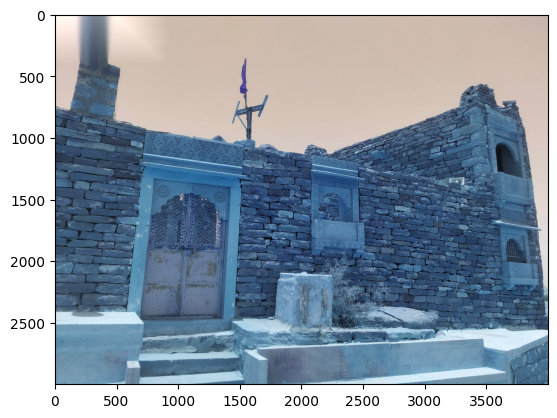

In [18]:
new1,mse1,pairwise,log = sift_matching(watermark_imgs)

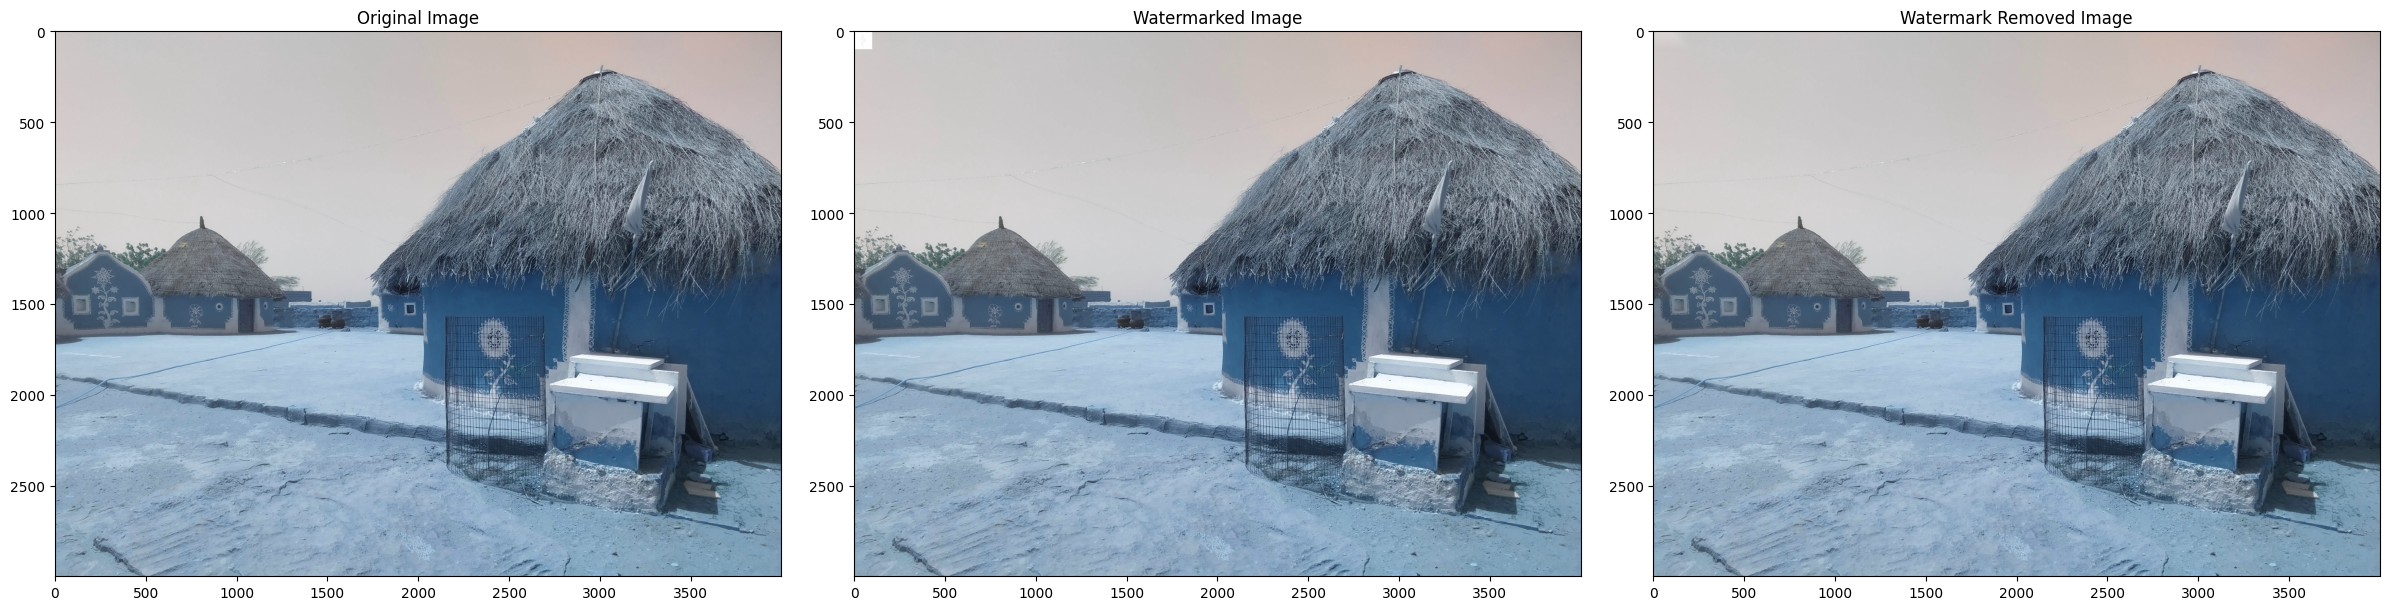

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(30, 20))
axs[0].imshow(oimg[1]),axs[0].set_title('Original Image')
axs[1].imshow(images[1]),axs[1].set_title('Watermarked Image')
axs[2].imshow(new1[1]),axs[2].set_title('Watermark Removed Image')
plt.subplots_adjust(wspace=0.1)
plt.show()